#### Urban Resilience Metrics Identification - Part 1

**Introduction**

The Rockefeller Foundation have been advocates for urban resilience. In 2013, the foundation initiated the "100 Resilient Cities (100RC)" program, targeting cities worldwide to bolster resilience against diverse challenges, encompassing physical, social, and economic aspects. This initiative not only addresses immediate shocks like earthquakes and floods but also focuses on daily stresses that deteriorate a city's fabric.

Our project's aim is to devise common resilience metrics. The methodology entails:
1. Formulating a list of terms corresponding to categories from the City Resilience Index(https://www.cityresilienceindex.org/#/city-profiles) using HuggingFace Model, unigrams, and bigrams. The top 20 recurring terms are stored in Terms_Overview.xlsx.
2. Leveraging 100RC_DataCollection.xlsx for city names and associated resilience report URLs. We then cross-match terms from Terms_Overview.xlsx for frequency using direct string matching and Spacy.
3. Aggregating frequency data and designing a dashboard analogous to the City Resilience Index.

**Notebook Overview**

This two-part notebook series caters to different analytical levels.

**Part 1**: This notebook facilitates a detailed analysis for individual cities. By accessing data from 100RC_Datacollection and Terms_Overview, users can:

* Retrieve and save city resilience reports in PDF and text formats.
* Match term frequencies within city reports.
* Identify sentences containing specific terms.
* Summarize reports using BERT and visualize term frequencies with histograms.

**Part 2**: The subsequent notebook amplifies the scope of analysis. It emphasizes:
* Bulk document storage.
* Cross-referencing term frequencies across cities.
* Implementing TF-IDF score computations.

**Using Part 1**  

This notebook integrates libraries like PyPDF2 for PDF manipulation, NLTK for text preprocessing, Spacy and Direct String Matching for term frequency analysis, BERT for summarization, and Matplotlib for visualization. On execution, users will be prompted to input a city name, post which the notebook sequentially activates the aforementioned functions.

By _Josh Jeon_

In [2]:
#Library Install
!pip install -q PyPDF2 requests nltk spacy textblob gensim matplotlib seaborn wordcloud geopandas bert-extractive-summarizer
!python -m spacy download en_core_web_sm


✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [3]:
#Library Load
import pandas as pd # Pandas library for data manipulation
import spacy # Spacy library for advanced Natural Language Processing
import nltk # NLTK library for natural language processing
import requests #Requests for making HTTP requests
from PyPDF2 import PdfReader #PdfReader from PyPDF2 for reading PDF files
from summarizer import Summarizer #BERT - Summarizer for text summarization
from nltk.tokenize import word_tokenize, sent_tokenize #NLTK for tokenizing text into words and sentences
from nltk.corpus import stopwords #Stopwords dataset from NLTK to remove common words
from nltk.stem import WordNetLemmatizer # Word lemmatization
import string #String module for common string operations
import matplotlib.pyplot as plt #Matplotlib for plotting and visualization



In [4]:
#DATA LOAD
#Load the resilience report (Contain City / URL)
Resilience_Collection = pd.read_excel('100RC_DataCollection.xlsx')

#Load a list of terms to check
terms_df = pd.read_excel('Terms_Overview.xlsx') 

all_terms = terms_df.values.flatten() #One Dimension
all_terms = [term.strip().lower() for term in all_terms 
             if isinstance(term, str)] #Excludes strings that are empty after stripping


In [20]:
# Map city names to their URLs
city_url_map = dict(zip(Resilience_Collection['City'], Resilience_Collection['Source']))

# Asks the user to input city name one wish to analyze
city_name = input("Enter the city name: ")

# Check if the entered city name exists in the dictionary
if city_name in city_url_map:
    pdf_url = city_url_map[city_name]
    print(f"The URL for {city_name} is: {pdf_url}")
else:
    print(f"No URL found for {city_name}. Please check the city name and try again.")

The URL for Surat is: https://resilientcitiesnetwork.org/downloadable_resources/Network/Surat-Resilience-Strategy-English.pdf


In [10]:
# PDF EXTRACTION

def download_and_extract_text(url, output_pdf_file, output_text_file):
    
    """
    Download PDF from URL, extract text, and save the text to a file.

    Parameters:
    - url: The URL of the PDF.
    - output_pdf_file: The name of the file to save the downloaded PDF.
    - output_text_file: The name of the file to save the extracted text.
    
    Returns:
    - str: The extracted text from the PDF.
    """
    
    #Writing to text
    response = requests.get(url)
    with open(output_pdf_file, 'wb') as f:
        f.write(response.content)
        
    with open(output_pdf_file, 'rb') as f:
        reader = PdfReader(f)
        text = ''.join(page.extract_text() for page in reader.pages)
        
    with open(output_text_file, 'w', encoding='utf-8') as f:
        f.write(text)
    return text

# Directories to save the PDF and text reports. (Saving to current directory)
pdf_directory = "./"
text_directory = "./"

#Naming files for reports
url = pdf_url
pdf_file = f'{city_name}-Resilience-Strategy-English.pdf'
text_file = f'{city_name}-Resilience-Strategy-English.txt'
city_name_text = download_and_extract_text(url, pdf_file, text_file).lower()


In [11]:
#PREPROCESSING
#Download NLTK Data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

#Preprocessing the text
def preprocess_text(text):
    
    """
    Preprocess the given text by tokenizing, removing stopwords, and lemmatizing.

    Parameters:
    - text: The text to preprocess.
    
    Returns:
    - list: The preprocessed sentences.
    """
    
    lemmatizer = WordNetLemmatizer() #Word Lemmatization
    
    stop_words = set(stopwords.words('english')) #Stop Words
    
    sentences = sent_tokenize(text) #Tokenizing text into sentences
    
    preprocessed_sentences = [] #Dictionary to hold preprocessed sentence
    
    #Looping through each sentence
    for sentence in sentences:
        #Removing punctutation and converting to lowercase
        sentence = sentence.translate(str.maketrans('', '', string.punctuation)).lower()
        #Tokenizing the sentence into words
        words = word_tokenize(sentence)
        #Lemmaitizing words and removing stopwords
        words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
        #Append the processed sentence to the list
        preprocessed_sentences.append(' '.join(words))
  
    return preprocessed_sentences

preprocessed_sentences_city_name = preprocess_text(city_name_text)
preprocessed_text_city_name = ' '.join(preprocessed_sentences_city_name)


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\lifet\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lifet\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\lifet\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\lifet\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Below, I've conducted frequency count of terms using both direct_string_matching and SpaCy Model. I've used the two as the work around they do frequency count differs. While SpaCy model does yield better results due to the efficiency of the model, to compare for accuracy of results, I've yielded both method in this analysis. (Applies to Notebook Part 2 as well)

In [12]:
#TERM EXTRACTION 

def direct_string_matching(terms, text):
    
    """
    Match terms in the text using direct string matching.

    Parameters:
    - terms: The terms to check.
    - text: The text to check for terms.
    
    Returns:
    - list: The terms and their frequencies in the text.
    """
    
    words = text.split()
    term_frequencies = {term: words.count(term) for term in terms}
    return sorted(term_frequencies.items(), key=lambda x: x[1], reverse=True)

def spacy_matching(terms, text):
    
    """
    Match terms in the given text using SpaCy.

    Parameters:
    - terms: The terms to check.
    - text: The text to check for terms.
    
    Returns:
    - list: The terms and their frequencies in the text.
    """
    
    #En_core_web_sm model load (Spacy Model)
    nlp = spacy.load('en_core_web_sm')
    #Process the text using Spacy
    doc = nlp(text)
    #Tokenize the processed text
    tokens = [token.text for token in doc]
    #Calculate the frequency of each term in the text
    term_frequencies = {term: tokens.count(term) for term in terms}
    #Sort terms based on their frequency in desc and return
    return sorted(term_frequencies.items(), key=lambda x: x[1], reverse=True)

def extract_term_frequencies(terms, preprocessed_sentences):
    
    """
    Extract term frequencies and the sentences in which they appear.

    Parameters:
    - terms: The terms to check.
    - preprocessed_sentences: The preprocessed sentences.
    
    Returns:
    - tuple: The term frequencies and the sentences in which they appear.
    """
    
    term_frequencies = {}
    
    term_phrases = {}
    #Loop through each termand calculate its frequency in the preprocessed sentences
    for term in terms:
        term_frequencies[term] = sum(sentence.count(term) for sentence in preprocessed_sentences)
        #Identify the sentences where the term appears
        term_phrases[term] = [sentence for sentence in preprocessed_sentences if term in sentence]
    return term_frequencies, term_phrases

term_frequencies, term_phrases = extract_term_frequencies(all_terms, preprocessed_sentences_city_name)


In [13]:
# SAVING RESULTS 
def save_terms_to_csv(term_frequencies, term_phrases, freq_filename="term_frequencies.csv", phrases_filename="term_phrases.csv"):
    
    """
    Save term frequencies and the sentences in which they appear to CSV files.

    Parameters:
    - term_frequencies: The term frequencies.
    - term_phrases: The sentences in which the terms appear.
    - freq_filename: The filename for the term frequencies. Defaults to "term_frequencies.csv".
    - phrases_filename: The filename for the term phrases. Defaults to "term_phrases.csv".
    
    Returns:
    - tuple: The paths of the saved CSV files for term frequencies and term phrases.
    """
    
    freq_path = "D:/Graduate School/Experience Expo/Code/City Frequency/"
    phrases_path = "D:/Graduate School/Experience Expo/Code/City Frequency Phrases/"
    
    freq_file_path = freq_path + freq_filename
    phrases_file_path = phrases_path + phrases_filename

    #Convert term frequencies to a DF and save to csv 
    df_term_frequencies = pd.DataFrame({
        'Term': list(term_frequencies.keys()),
        'Frequency': list(term_frequencies.values())
    })

    #Convert to DF - Save to csv
    df_term_phrases = pd.DataFrame({
        'Term': list(term_frequencies.keys()),
        'Sentences': [", ".join(term_phrases[term]) for term in term_frequencies.keys()]
    })

    df_term_frequencies.to_csv(freq_file_path, index=False)
    df_term_phrases.to_csv(phrases_file_path, index=False)

    return freq_file_path, phrases_file_path

freq_filename = f"{city_name}_frequencies.csv"
phrases_filename = f"{city_name}_term_phrases.csv"
saved_freq_file, saved_phrases_file = save_terms_to_csv(term_frequencies, term_phrases, freq_filename, phrases_filename)

print(f"Files saved as: {saved_freq_file}, {saved_phrases_file}")


Files saved as: D:/Graduate School/Experience Expo/Code/City Frequency/Surat_frequencies.csv, D:/Graduate School/Experience Expo/Code/City Frequency Phrases/Surat_term_phrases.csv


In [14]:
# REPORT SUMMARIZATION ---
# Summarize the resilience report using BERT
model = Summarizer()
summary = model(city_name_text, num_sentences=25) 
print("Summary of Report:")
print(summary)

Summary of Report:
a
photograph credit: tejas ghariwala, suratsurat resilience strategysteered by:
supported by: 
strategic partner: 
taru leading edge pvt. s. aparna, ias, former municipal commissioner, smcmr. p. m. shah, vice-president, sgcci & trustee, scctdr. at present, the main source of water for the entire city is the river tapi. surat faces risks of both sea level rise and flooding. the objective of 
the resilience strategy is to provide a roadmap for the chief 
resilience officer (cro) to build resilience in the city. surat is considered a model city for good governance as well 
as for providing effective service delivery in comparison with many other indian cities. the development of 
detailed project reports (dprs) can be the next logical step 
for the city government to access financial resources apart 
from the state or national government. an increase in 
the number of nonlicensed drivers has also been observed in 
the city. this research will help the surat city police 

In [15]:
#DISPLAY RESULTS ---
direct_results = direct_string_matching(all_terms, preprocessed_text_city_name)
spacy_results = spacy_matching(all_terms, preprocessed_text_city_name)
print("\nDirect String Matching Results:", direct_results[:30])
print("\nSpaCy Matching Results:", spacy_results[:30])



Direct String Matching Results: [('city', 515), ('water', 197), ('development', 156), ('strategy', 144), ('housing', 83), ('awareness', 74), ('policy', 73), ('health', 73), ('community', 61), ('management', 59), ('technology', 56), ('transport', 53), ('government', 50), ('affordable', 46), ('plan', 38), ('support', 37), ('education', 33), ('environment', 32), ('infrastructure', 30), ('risk', 29), ('network', 29), ('police', 28), ('monitoring', 28), ('planning', 26), ('energy', 26), ('enforcement', 26), ('business', 25), ('capacity', 23), ('ecosystem', 22), ('heritage', 21)]

SpaCy Matching Results: [('city', 515), ('water', 198), ('development', 156), ('strategy', 144), ('housing', 84), ('awareness', 74), ('health', 74), ('policy', 73), ('community', 61), ('management', 59), ('technology', 56), ('transport', 54), ('government', 50), ('affordable', 46), ('plan', 38), ('support', 37), ('education', 33), ('environment', 32), ('infrastructure', 30), ('risk', 30), ('network', 29), ('police

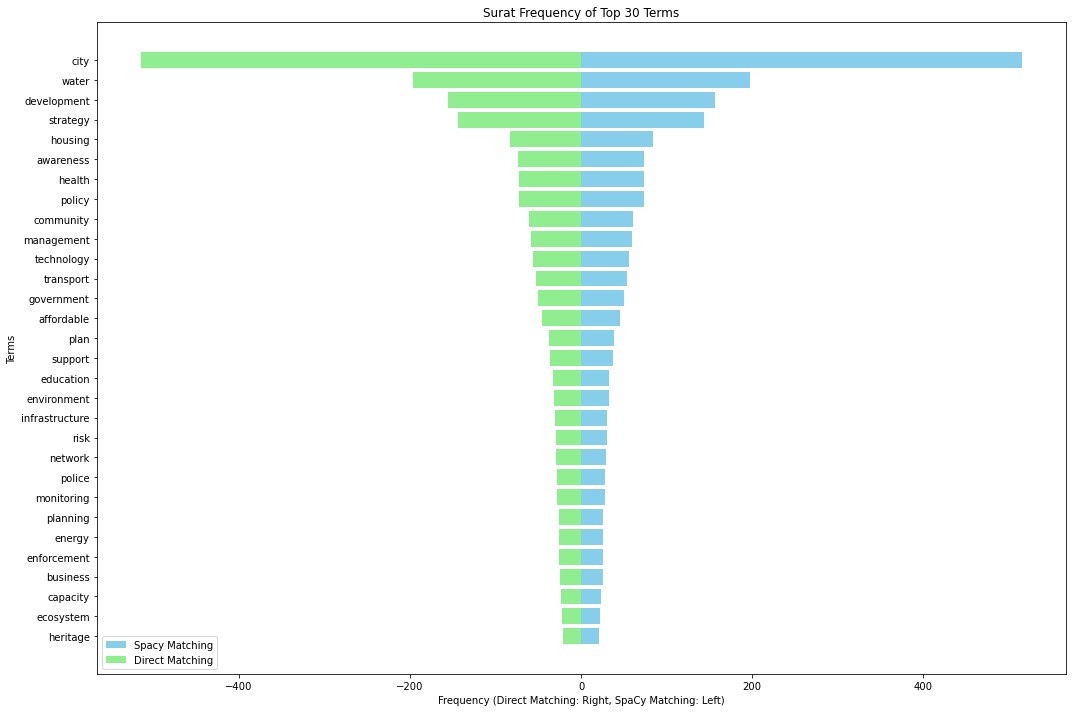

In [18]:
#PLOTTING 
df_spacy = pd.DataFrame(spacy_results[:30], columns=['Term', 'Spacy_Frequency'])
df_direct = pd.DataFrame(direct_results[:30], columns=['Term', 'Direct_Frequency'])

plt.figure(figsize=(15,10))
plt.barh(df_spacy['Term'], df_spacy['Spacy_Frequency'], color='skyblue', label='Spacy Matching')
plt.barh(df_direct['Term'], -df_direct['Direct_Frequency'], color='lightgreen', label='Direct Matching')
plt.xlabel('Frequency (Direct Matching: Right, SpaCy Matching: Left)')
plt.ylabel('Terms')
plt.title(f'{city_name} Frequency of Top 30 Terms')
plt.gca().invert_yaxis()
plt.legend()
plt.tight_layout()
plt.show()
